Hunter Bennett  
Glass Lab  
Created 180205 | Last updated 180205  
____________  
here we are seeking to understand if there are noticeable molecular phenotype within 4 weeks on the NASH diet.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import subprocess
import os
import sys
import glob
import re

# import user defined packages
sys.path.insert(0, '/home/h1bennet/scripts')
import hbUtils

# plot matplotlib plots in notebook
%matplotlib inline

# load extension for running R from python
#  %load_ext rpy2.ipython

sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

Make output directory

In [2]:
# define output directory
outdir = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(outdir):
    subprocess.call(['mkdir', outdir])

In [3]:
# set working directory
workingDirectory = '/home/h1bennet/liverStrains/results/180517_RNASeq_NASH_Timecourse/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

In [4]:
# import mm10 to refseq id gene mapper
mm10_refseq = pd.read_csv('/home/h1bennet/LXR/data/mm10_refseq_genename.txt', sep='\t', names=['refseq_id', 'gene'], index_col=0)

Set some user defined functions

In [5]:
def tpm_paired_scatter(tpm, strain, tissue):
    tmp_df = hbUtils.df_col_subset(tpm, strain + '.*' + tissue)
    tmp_df.columns = pd.Series(tmp_df.columns).str.extract('[_-]([a-zA-Z]+[0-9]+[a-zA-Z]{0,2})[_-]',
                                                                   flags=re.IGNORECASE, expand=False)
    tmp_df.columns = pd.Series(tmp_df.columns).replace(np.nan, 'NNaF')
    g = sns.PairGrid(np.log2(tmp_df + 1))
    g = g.map(plt.scatter)
    corrs = np.log(tmp_df + 1).corr().values.flatten()
    for ax, corrval in zip(g.axes.flat, corrs):
        ax.text(0, 16, "r = %.2f" % corrval, fontsize=9)

            
# define function for labeling points in scatterplots
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))


### Do Some RNA QC

In [6]:
%%bash
if [ ! -d ./qc_rna/ ]; then mkdir ./qc_rna; fi

In [7]:
# make summary table of qc stats
qc_stats = pd.DataFrame()

for sample in os.listdir('./tag_directories_rna/'):
    # pull tag information from HOMER output file
    tag_info_df = pd.read_table('./tag_directories_rna/'+sample+'/tagInfo.txt', sep='\t')
    qc_stats.loc[sample, 'uniquePositions'] = int(tag_info_df.iloc[0, 1])
    qc_stats.loc[sample, 'fragmentLengthEstimate'] = int(tag_info_df.iloc[1, 0].split('=')[1])
    qc_stats.loc[sample, 'tagsPerBP'] = float(tag_info_df.iloc[3, 0].split('=')[1])
    qc_stats.loc[sample, 'clonality'] = float(tag_info_df.iloc[4, 0].split('=')[1])
    qc_stats.loc[sample, 'GC_Content'] = float(tag_info_df.iloc[7, 0].split('=')[1])
    # f = open('./tag_directories_atac/'+sample+'/'+sample+'.mm10.bowtie2.log')
    # get mapping stats from bowtie log
    for file in os.listdir('./tag_directories_rna/'+sample+'/'):
        if file.endswith(".log"):
            f = open('./tag_directories_rna/'+sample+'/'+file)
            txt = f.read()
            star_log = list(filter(None, re.split('\s|\|',txt)))
            qc_stats.loc[sample, 'totalReads'] =int(star_log[29])
            qc_stats.loc[sample, 'uniquelyMappedReads'] = int(star_log[41])
            qc_stats.loc[sample, 'multiMappedReads'] = int(star_log[115])
            qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = float(star_log[151].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_short'] = float(star_log[158].strip('%'))/100
            qc_stats.loc[sample, 'frac_unmappedReads_other'] = float(star_log[164].strip('%'))/100
            qc_stats.loc[sample, 'uniquelyMappedFraction'] = \
                                                    qc_stats.loc[sample, 'uniquelyMappedReads'] \
                                                    / qc_stats.loc[sample, 'totalReads']
            qc_stats.loc[sample, 'mappedFraction'] = 1 \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_other'] \
                                            - qc_stats.loc[sample, 'frac_unmappedReads_short'] \
                                            - qc_stats.loc[sample, 'totalReads']
    if not any(fname.endswith('.log') for fname in os.listdir('./tag_directories_rna/'+sample+'/')):
        print(sample + ' does not contain a mapping log file')
        qc_stats.loc[sample, 'totalReads'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedReads'] = np.nan
        qc_stats.loc[sample, 'multiMappedReads'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_mismatch'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_short'] = np.nan
        qc_stats.loc[sample, 'frac_unmappedReads_other'] = np.nan
        qc_stats.loc[sample, 'uniquelyMappedFraction'] = np.nan
        qc_stats.loc[sample, 'mappedFraction'] = np.nan

qc_stats.sort_index(inplace=True)
qc_stats.to_csv('./qc_rna/mapping_stats.tsv', sep='\t')

C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN12aM does not contain a mapping log file


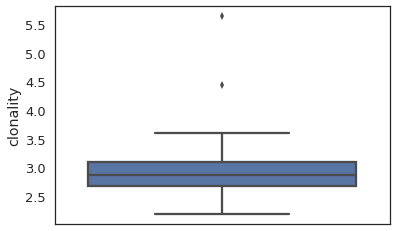

In [8]:
# clonality boxplot
fig = sns.boxplot(y=qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna/clonality_boxplot_hb.pdf', bbox_inches='tight')

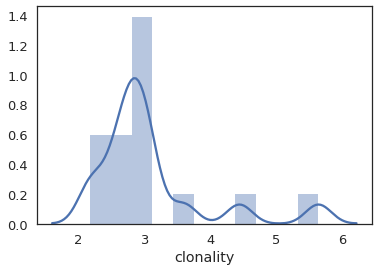

In [9]:
# clonality distplot
fig = sns.distplot(qc_stats['clonality']).get_figure()
fig.savefig('./qc_rna/clonality_distplot_hb.pdf', bbox_inches='tight')

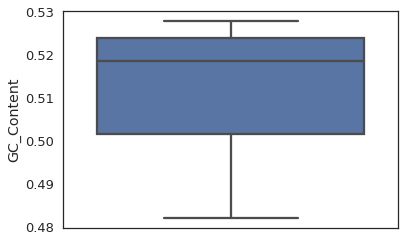

In [10]:
# GC_Content boxplot
fig = sns.boxplot(y=qc_stats['GC_Content']).get_figure()
fig.savefig('./qc_rna/GC_Content_boxplot_hb.pdf', bbox_inches='tight')

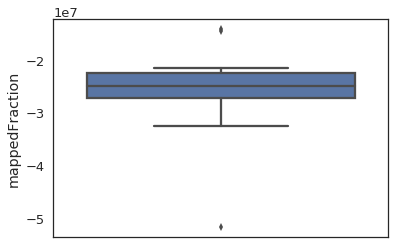

In [11]:
# mapped fraction boxplot
fig = sns.boxplot(y=qc_stats['mappedFraction']).get_figure()
fig.savefig('./qc_rna/mappedFraction_boxplot_hb.pdf', bbox_inches='tight')

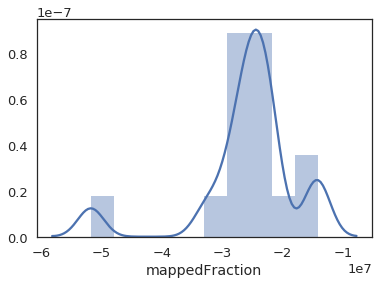

In [12]:
# mapped fraction distplot
fig = sns.distplot(qc_stats['mappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna/mappedFraction_distplot_hb.pdf', bbox_inches='tight')

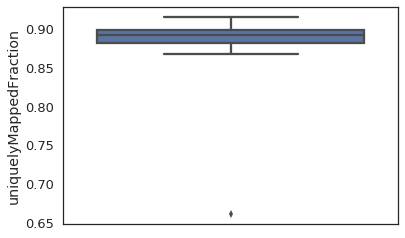

In [13]:
# uniquely Mapped Fraction boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedFraction_boxplot_hb.pdf', bbox_inches='tight')

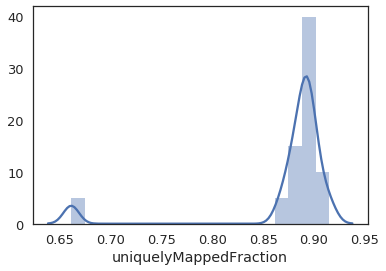

In [14]:
# uniquely Mapped Fraction distplot
fig = sns.distplot(qc_stats['uniquelyMappedFraction'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedFraction_distplot_hb.pdf', bbox_inches='tight')

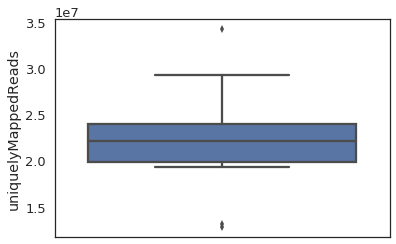

In [15]:
# uniquely Mapped Reads boxplot
fig = sns.boxplot(y=qc_stats['uniquelyMappedReads'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

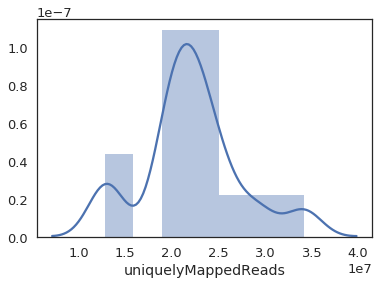

In [16]:
# uniquely Mapped Reads distplot
fig = sns.distplot(qc_stats['uniquelyMappedReads'].dropna()).get_figure()
fig.savefig('./qc_rna/uniquelyMappedReads_distplot_hb.pdf', bbox_inches='tight')

### Generate RNA Seq Files

In [22]:
%%bash
# if directories don't exist, create them
if [ ! -d ./expression/ ]; then mkdir ./expression; fi

analyzeRepeats.pl rna mm10 -count exons -condenseGenes -raw -d ./tag_directories_rna/* > ./expression/rna_exp_raw.tsv
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d ./tag_directories_rna/* > ./expression/rna_exp.tsv
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d ./tag_directories_rna/* > ./expression/rna_exp_rpkm.tsv

	Tag Directories:
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574A
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_1wk_C574B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN200cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN201cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_20wk_LN203dM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN144B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146C
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN146D
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_30wk_LN152B
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN352A
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_AMLNDiet_4wk_LN354D
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN12aM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN36cM
		./tag_directories_rna/C57Bl6_KupfferTim4Pos_RNA_Control_0wk_LN38

In [27]:
# %%bash
# makeMultiWigHub.pl hrb_tim4pos_timecourse_hub mm10 -force -d ./tag_directories_rna/*

In [28]:
# %%bash
# source activate rrrr
# getDiffExpression.pl ./expression/rna_exp_raw.tsv 1wk 1wk 20wk 20wk 20wk 30wk 30wk 30wk 30wk 4wk 4wk 0wk 0wk_control 0wk_control 20wk_control 20wk_control -AvsA > ./expression/diff_output.txt

In [17]:
# import differential gene expression
diff_gene = pd.read_csv('./expression/diff_output.txt', sep='\t', index_col=0)

# create gene name index
diff_gene = diff_gene.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
diff_gene = diff_gene.reset_index().set_index('gene').drop(columns='index')

In [18]:
diff_gene.loc['Scd2', :]

chr                                                                                                                                     chr19
start                                                                                                                                44293676
end                                                                                                                                  44306862
strand                                                                                                                                      +
Length                                                                                                                                   5443
Copies                                                                                                                                      1
Annotation/Divergence                                                                       Scd2|Mir5114|Scd-2|mir-5114|swty|-|19 C3|19 37...
./tag_

###  First take a look at pairwise scatterplots of the individuals

we will use a tpm matrix for most of our plotting

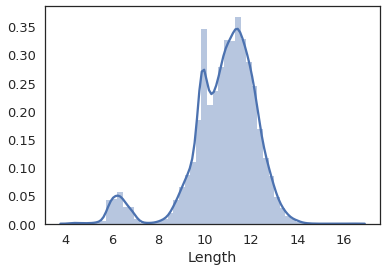

In [19]:
rpkm = pd.read_csv(outdir + './expression/rna_exp_rpkm.tsv', sep='\t')
# set rpkm index
rpkm.set_index(rpkm.columns.values[0], inplace=True)
rpkm.index.rename('refseqID', inplace=True)

# clean up column names
# rename rpkm columns
rpkm = rpkm.rename(columns=dict(zip(rpkm.iloc[:, 7:].columns.values,
                                    pd.Series(rpkm.iloc[:, 7:].columns.values).str[:-5].str.split('/').str[-1])))

sns.distplot(np.log2(rpkm.Length + 1))

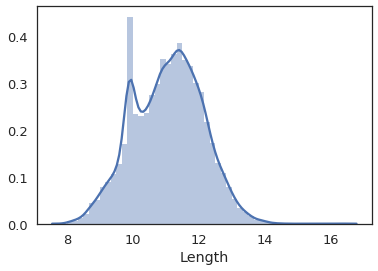

In [20]:
# Filter small mRNAs (transcriptsdd with length < 250 - mostly snoRNAs)
rpkm = rpkm.loc[rpkm.Length >= 250, :]
sns.distplot(np.log2(rpkm.Length + 1))

### Create sample datasheet

In [21]:
samples = pd.Series(rpkm.iloc[:, 7:].columns.values)
cage = samples.str.split('_').str[-1]
group = ['_'.join(i) for i in samples.str.split('_').str[:-1]]

samplesDF = pd.DataFrame([pd.Series(samples),
              pd.Series(cage),
              pd.Series(group)],
              index=['sample', 'cage', 'group']).T


# Descriptive analysis of our data

In [22]:
# Import packages for PCA analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # uses SVD

# standardize matrix, mean=0, std=1
rpkm_std = StandardScaler().fit_transform(rpkm.iloc[:, 7:])
# run PCA
pca = PCA(n_components=3)
tpm_pca = pca.fit_transform(rpkm_std.T)
exp_var = pca.explained_variance_ratio_
#create df for plotting
tpm_pca_df = pd.DataFrame(tpm_pca, columns=['PC1', 'PC2', 'PC3'],
        index=([samplesDF.group])).reset_index()
tpm_pca_df['cage'] = samplesDF['cage']

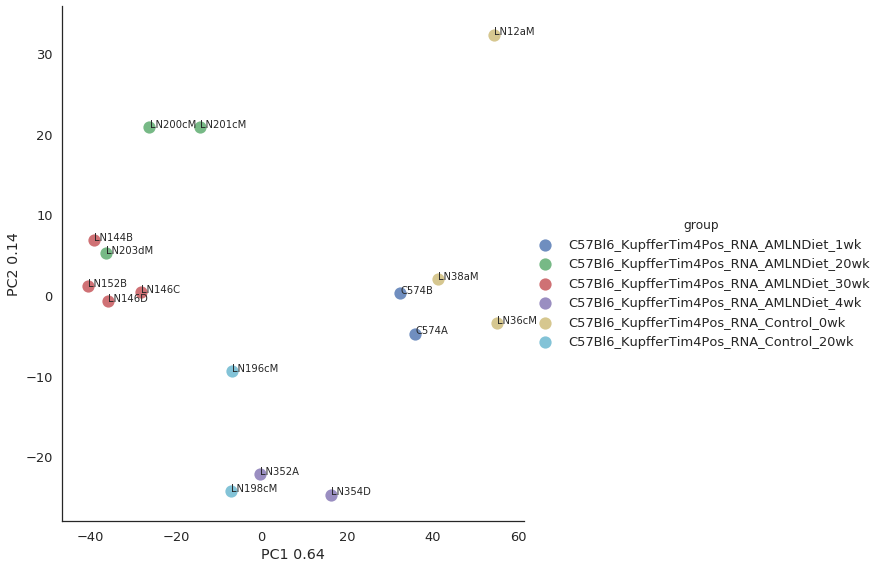

In [23]:
ax = sns.lmplot('PC1', 'PC2', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=8, scatter_kws={'s': 150},
                legend=True)
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC1, tpm_pca_df.PC2, tpm_pca_df.cage, plt.gca())

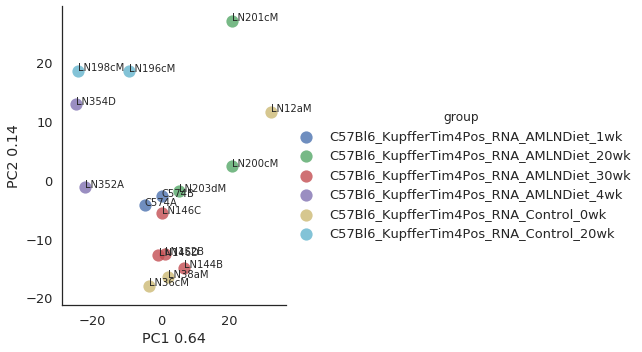

In [24]:
ax = sns.lmplot('PC2', 'PC3', tpm_pca_df, fit_reg=False,
                hue='group', # palette=color_dict,
                size=5, scatter_kws={'s': 150})
ax.set(xlabel=('PC1 %.2f' % exp_var[0]), ylabel=('PC2 %.2f' % exp_var[1]))
label_point(tpm_pca_df.PC2, tpm_pca_df.PC3, tpm_pca_df.cage, plt.gca())

In [25]:
transcript_pc = pd.DataFrame(pca.components_.T, rpkm.index, columns=['PC1','PC2','PC3'])

In [26]:
# look at the genes with the highest loading in PC1
transcript_pc.sort_values(by = 'PC1', ascending=False).head(10)

,PC1,PC2,PC3
refseqID,,,
NM_016751,0.299222,-0.164182,-0.005939
NM_021278,0.297361,-0.083216,-0.435223
NM_007995,0.184801,-0.106802,-0.018717
NM_007572,0.173550,-0.108950,-0.073554
NM_009690,0.171063,0.081199,0.141163
NM_007574,0.163750,-0.030440,-0.045446
NM_001081957,0.162351,-0.026766,-0.111673
NM_009735,0.160664,0.090769,-0.174084
NM_177789,0.140596,0.011115,-0.069492


### Heatmap

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


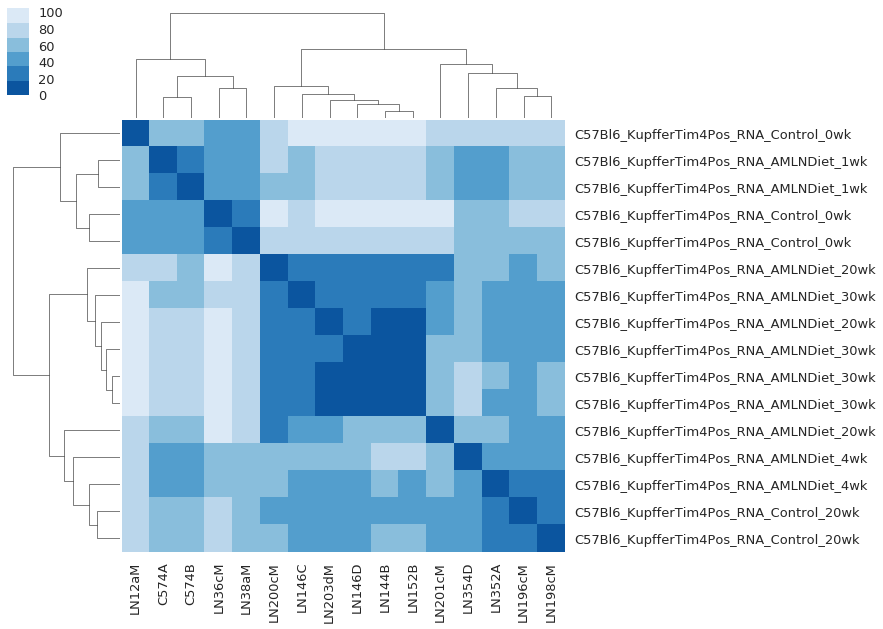

In [27]:
from scipy.spatial import distance
rpkm_dist = pd.DataFrame(distance.squareform(distance.pdist(rpkm_std.T, 'euclidean')),
                        columns = list(samplesDF.cage),
                        index = list(samplesDF.group))
# plot values using sns clustermap - ignore error as we know we are putting in a distance mat
g = sns.clustermap(rpkm_dist, cmap=sns.color_palette("Blues_r"))

# Import DESeq2 results

In [28]:
deseq_4wk = pd.read_csv('../180412_RNA_4wk/rnaseq_c57bl6_amln_4wk_deseq_results.txt',
                        sep=',', index_col=0).merge(mm10_refseq,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')
deseq_1wk = pd.read_csv('../180412_RNA_4wk/rnaseq_c57bl6_amln_1wk_deseq_results.txt',
                        sep=',', index_col=0).merge(mm10_refseq,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')

# read in 1 wk vs 4 wk DESeq2 table
deseq_4wk_1wk = pd.read_csv('../180412_RNA_4wk/rnaseq_c57bl6_amln_4wk_1wk_deseq_results.txt',
                            sep=',', index_col=0).merge(mm10_refseq,
                                                    left_index=True,
                                                    right_index=True,
                                                    how='left')

### Set p value and fc cutoffs

In [29]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

### 4 week diet effect

In [30]:
# get gene lists
c57bl6_amln_4wk_deseq_p01_fc2_up = deseq_4wk.loc[
        ((deseq_4wk.padj <= pval) & (deseq_4wk.log2FoldChange > fc)), 'gene']

c57bl6_amln_4wk_deseq_p01_fc2_dn = deseq_4wk.loc[
        ((deseq_4wk.padj <= pval) & (deseq_4wk.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open('./gene_lists/c57bl6_amln_4wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open('./gene_lists/c57bl6_amln_4wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 1 week diet effect

In [31]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_1wk_deseq_p01_fc2_up = deseq_1wk.loc[
        ((deseq_1wk.padj <= pval) & (deseq_1wk.log2FoldChange > fc)), 'gene']

c57bl6_amln_1wk_deseq_p01_fc2_dn = deseq_1wk.loc[
        ((deseq_1wk.padj <= pval) & (deseq_1wk.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + './gene_lists/c57bl6_amln_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + './gene_lists/c57bl6_amln_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_1wk_deseq_p01_fc2_dn.tolist())
f.write(gene_list)
f.close()

### 4 vs 1 week diet effect

In [32]:
#### Write gene list for analysis with metascape
pval = 0.01 # p value cutoff
fc = 1 # fc cutoff for interesting genes

# get gene lists
c57bl6_amln_4wk_1wk_deseq_p01_fc2_up = deseq_4wk_1wk.loc[
        ((deseq_4wk_1wk.padj <= pval) & (deseq_4wk_1wk.log2FoldChange > fc)), 'gene']

c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn = deseq_4wk_1wk.loc[
        ((deseq_4wk_1wk.padj <= pval) & (deseq_4wk_1wk.log2FoldChange < -fc)), 'gene']

# write output for uploading to metascape
f = open(outdir + './gene_lists/c57bl6_amln_4wk_1wk_deseq_p01_fc2_up_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_up.tolist())
f.write(gene_list)
f.close()

f = open(outdir + './gene_lists/c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn_genes.txt', 'w')
gene_list = '\n'.join(['geneID'] +  c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn.dropna().tolist())
f.write(gene_list)
f.close()

# Comparing Differential Gene Expression

In [33]:
tpm_mat = (rpkm.iloc[:, 7:] / rpkm.iloc[:, 7:].sum()) * 1000000

In [34]:
# create avg tpm matrix for filtering
tpm_avg = pd.DataFrame([
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_1wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_20wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_30wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('AMLNDiet_4wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_0wk'))].mean(1),
    tpm_mat.loc[:, list(samplesDF.group.str.contains('Control_20wk'))].mean(1)],
    index=['AMLNDiet_1wk', 'AMLNDiet_20wk', 'AMLNDiet_30wk',
           'AMLNDiet_4wk', 'Control_0wk', 'Control_20wk']).T

# filter genes not expressed at least 1 tpm across more than half of samples
tpm_mat_filt = tpm_mat.loc[(tpm_avg > 4).any(1), :]

# change index to gene names
tpm_mat_filt = tpm_mat_filt.merge(mm10_refseq, how='left', left_index=True, right_index=True).drop_duplicates()
tpm_mat_filt = tpm_mat_filt.reset_index().set_index('gene').drop(columns='index')

# sort columns (manually for now)
cols = tpm_mat_filt.columns.values
tpm_mat_filt = tpm_mat_filt.reindex([cols[11], cols[12],
                      cols[0], cols[1], cols[9],
                      cols[10], cols[2], cols[3],
                      cols[4], cols[5], cols[6],
                      cols[7], cols[8]], axis=1)

tpm_mat_zscore = tpm_mat_filt.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

Lets just look at the ge patterns for 1 week differential genes

1334


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


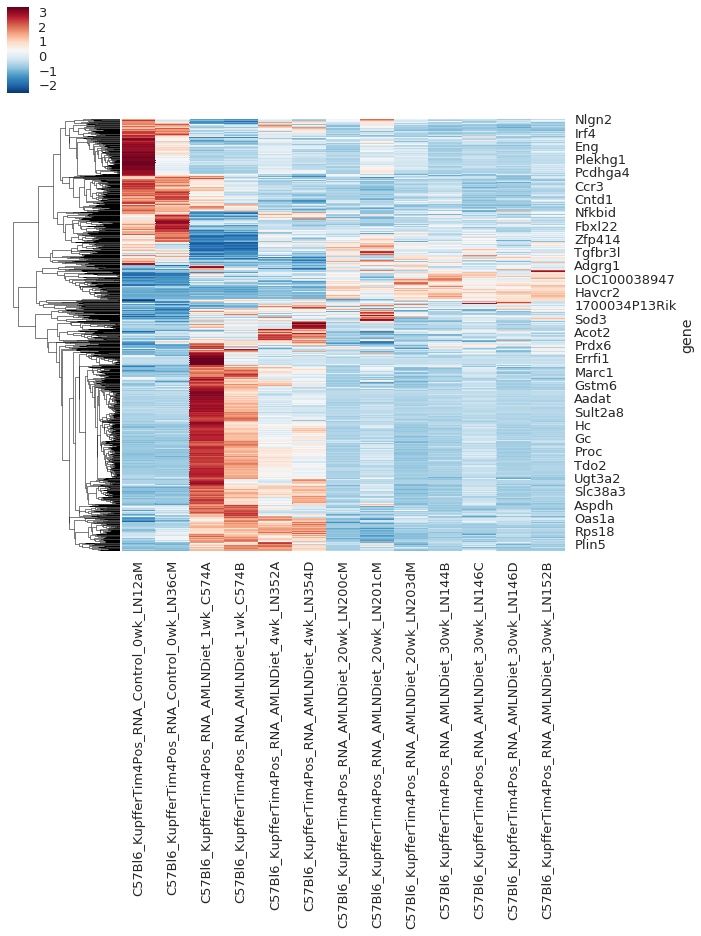

In [35]:
x = list(c57bl6_amln_1wk_deseq_p01_fc2_dn)
x.extend(list(c57bl6_amln_1wk_deseq_p01_fc2_up))
x.extend(list(c57bl6_amln_4wk_deseq_p01_fc2_up))
x.extend(list(c57bl6_amln_4wk_deseq_p01_fc2_dn))
x = set(x)
print(len(x))
sns.clustermap(tpm_mat_filt.loc[x, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

Lets call DE genes on 30 week and 20 week then take ones that are significant at any time point then look at the FC pattern.

### What about genes that are downregulated and stay low

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


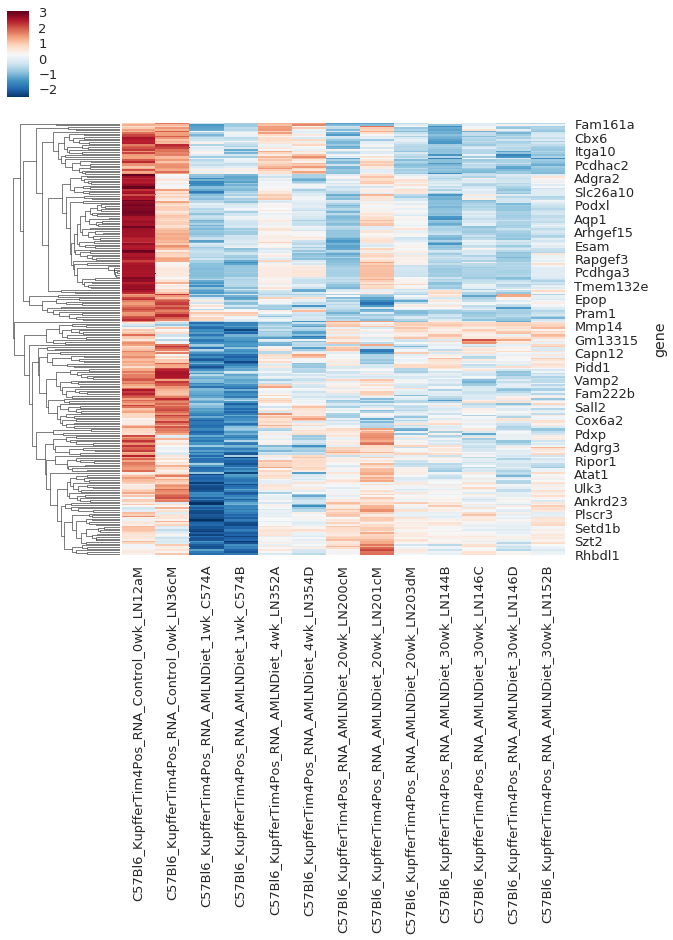

In [36]:
sns.clustermap(np.log2(tpm_mat_filt.loc[c57bl6_amln_1wk_deseq_p01_fc2_dn, :].dropna() + 1), z_score=0, cmap='RdBu_r', col_cluster=False)

How many genes go up then down week 1 to 4 vs down to up week 1 to 4?

In [37]:
deseq_down_up = list(set(c57bl6_amln_1wk_deseq_p01_fc2_dn).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
deseq_down_up_refseq = mm10_refseq.loc[[(gene in deseq_down_up) for gene in mm10_refseq.gene], :].index.tolist()

deseq_up_down = list(set(c57bl6_amln_1wk_deseq_p01_fc2_up).intersection(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
deseq_up_down_refseq = mm10_refseq.loc[[(gene in deseq_up_down) for gene in mm10_refseq.gene], :].index.tolist()

In [38]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_dn))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_up))
print(len(deseq_down_up))

314
125
49


In [39]:
print(len(c57bl6_amln_1wk_deseq_p01_fc2_up))
print(len(c57bl6_amln_4wk_1wk_deseq_p01_fc2_dn))
print(len(deseq_up_down))

805
209
122


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


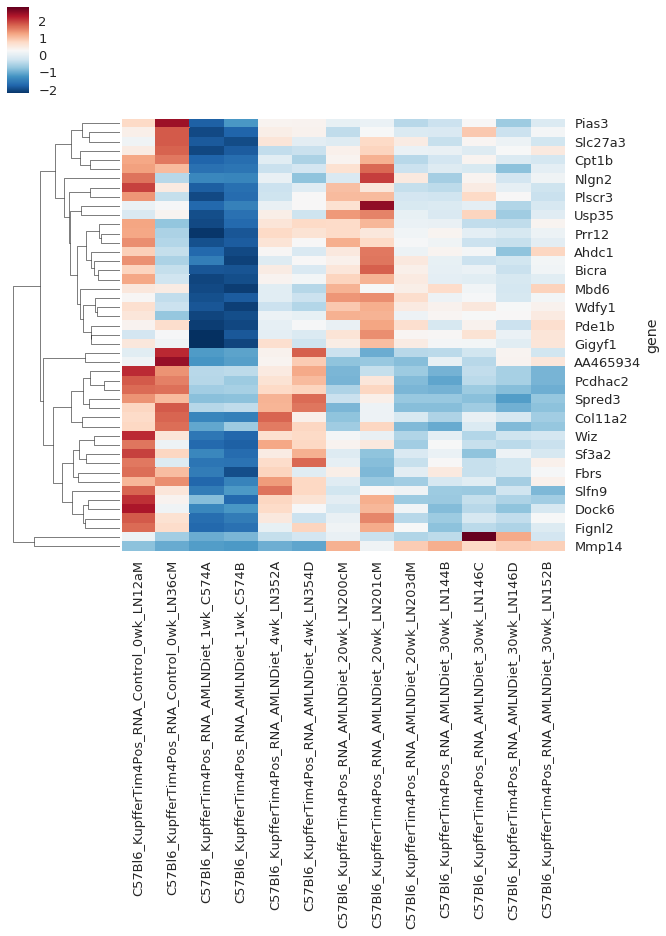

In [40]:
sns.clustermap(tpm_mat_filt.loc[deseq_down_up, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

* Slc27a3 is a long chain fatty acid metabolic compount (acyl-CoA ligase) in mitochondrial beta oxidation gene, FA + CoA +ATP --> Acyl-CoA + AMP. Maybe 1 week KCs are turning off beta oxidation?
* Cpt1b rate controlling enzyme of long chain fatty acid beta oxidation, transports FA into mitochondria from cytoplasm
* Spred3 and Tnk1 both negatively regulate the MAPK pathway
* Setd1b is part of HMT complex that trimethylates H3 at Lys4
* Adgrg6 activated by type IV collagen
* Atn is transcriptional corepressor. Phf21b is a TF. Maml3 is a NOTCH coactivator
* FBRS induces fibroblasts proliferation
* Col11a2 and Col7a1 collagen compounds (obviously), mmp14 breaks down collagen
* Marco is classic KC gene - scavenger receptor for gram negative and gram positive bacteria
* Kcp inhibits TGFB signaling

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


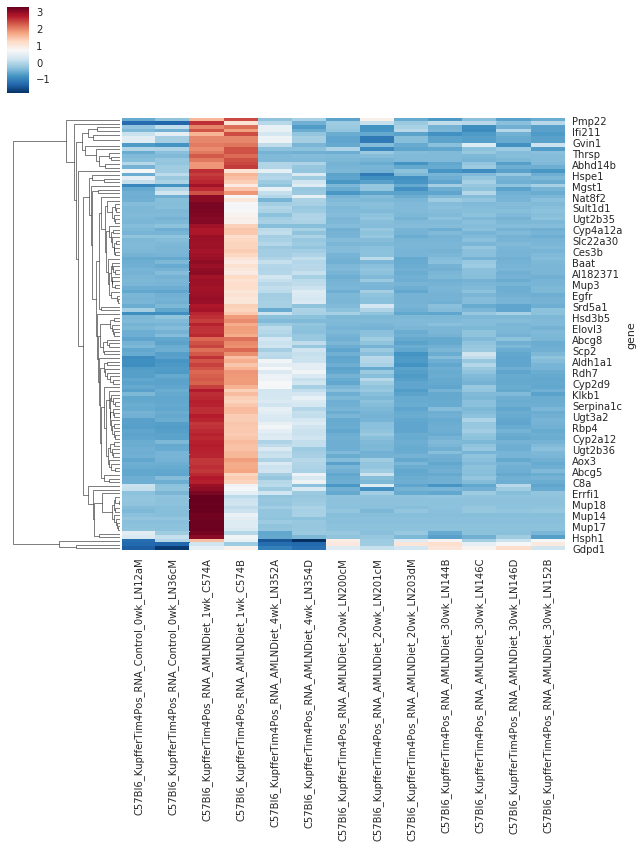

In [41]:
sns.set(font_scale=1)
sns.clustermap(tpm_mat_filt.loc[deseq_up_down, :].dropna(), z_score=0, cmap='RdBu_r', col_cluster=False)

In [42]:
', '.join(deseq_up_down)

'Pmp22, Cyp2f2, Mup11, Pex13, Cyp2c50, Hspe1, Serpina4-ps1, Cyp4a12a, Srd5a1, Gm4788, Elovl3, Pklr, Mup16, Ahcy, Sardh, Ifi208, Ghr, Hsd3b5, Aldh6a1, Ugt2a3, Slc10a1, Fmo5, Mup17, Cldn1, Slfn8, Cyp4f14, Errfi1, Cyp2d9, Serpina1b, Mup9, Kmo, Klkb1, Cyp2j5, Gulo, Rpl29, Abhd14b, Akr1c6, Gm4070, Hsp90aa1, Aox3, 2610507I01Rik, Mup14, Myo1b, Cps1, Scp2, Dhx40, AI182371, Egfr, Ifi209, Abcg8, Serpina3k, Hsd3b3, Pon1, Ifi211, Ifi205, Specc1, Saa4, Mapkapk3, Uox, Cfhr2, Ugt2b5, Hao1, Nudt7, Hspb8, Mup21, Serpina1a, Selenbp2, Elovl2, C8b, Ugt2b34, Dio1, Azgp1, Rida, Rbp4, Tdo2, G530011O06Rik, Serpina12, Ces3b, Ugt3a2, Slc22a30, Mup3, Thrsp, Ugt2b35, Cfhr1, Mgst1, Keg1, C9, Otc, Mup18, Aadac, Slc6a13, Dpyd, Cyp2c70, Ccl2, Slco1a1, Cxadr, Serpina1d, Sult1d1, C8a, Gdpd1, Ces2a, Adh1, Gvin1, Ugt2b36, Mup20, Rdh7, Apoa2, Cyp3a25, Cyp2c67, Abcg5, Aldh1a1, Cyp2c68, Ces2c, Hsph1, Nat8f2, Baat, Abcb11, Cyp2a12, Gm2083, Ndrg2, Adk, Serpina1c'

* Mapkapk3 activated by map kinase. Phosphorylates inflammatory genes
* Ifi205 activates NLRP3 inflammasome in resposne to
* Hsd3b5 is a steroid biosynthesis pathway enzyme, Cyp4a12 is a steroid oxidizer
* Cyp2c mice involved  in conjugation and creation of bile acids.
* Rdh7 is involved in retinol metabolism

### How do KC Specific Genes change

In [43]:
import scipy.cluster

278
275


/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See 

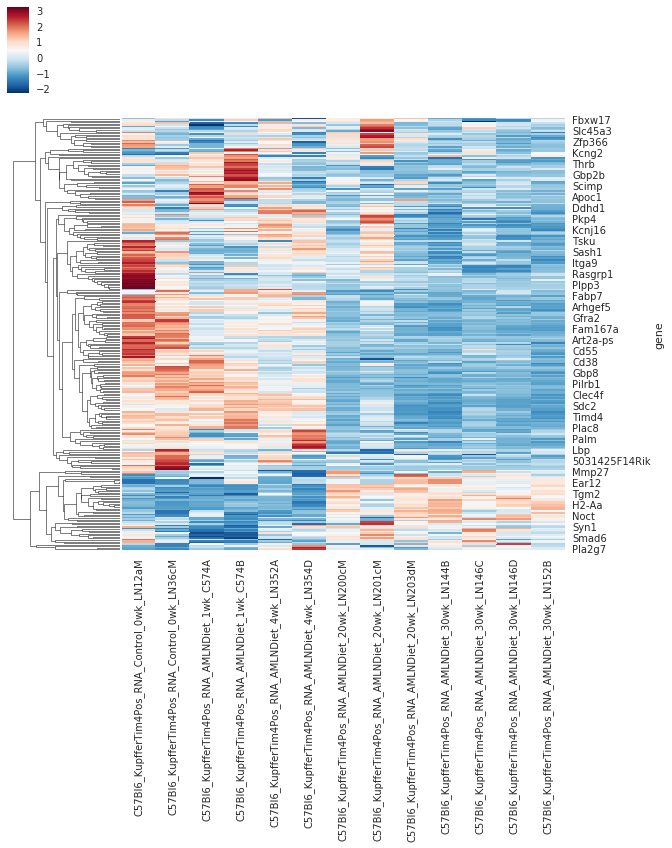

In [44]:
with open('/home/h1bennet/liverStrains/data/mouse/KC_specific_C57_AJ_BALB.txt', 'r') as f:
    kc_genes = [i.strip('"') for i in f.read().split()]

print(len(kc_genes))
print(tpm_mat_zscore.loc[kc_genes, :].dropna().shape[0])
rowclust = scipy.cluster.hierarchy.linkage(tpm_mat_zscore.loc[kc_genes, :].dropna(),
                                           method='average')

kc = sns.clustermap(tpm_mat_filt.loc[kc_genes, :].dropna(),
                    z_score=0, cmap='RdBu_r', col_cluster=False,
                    row_linkage=rowclust)

kc.savefig('./figures/KC_specific_C57_AJ_Balb_heatmap.png', bbox_inches='tight')

In [45]:
row_two_clust = (scipy.cluster.hierarchy.cut_tree(rowclust, n_clusters=2) == 1)
row_two_clust = [i[0] for i in row_two_clust]

In [46]:
de_sermut_genes = ['Nnmt', 'Hamp2', 'Thrsp',
                   'Ppp1r3g', 'Cyp2c69', 'Cyp2b13',
                   'Cyp2b9', 'Ces1f', 'Slc22a26',
                   'Bex1', 'Syngr1', 'Wfdc3',
                   'Fabp5', 'Timp1', 'Atp06vd2',
                   'Scara3', 'Obspl3', 'Cx3cr1',
                   'Col1a1', 'Spp1', 'Osbpl3',
                   'Acss3', 'Elovl3', 'Fads1',
                   'Fads2', 'Elovl5', 'Ascl1',
                   'Acox1', 'Acaa1b', 'Acad11',
                   'Acadm']

Plot genes from the mutated serine mice in the Becares et al 2017 BioRXiv paper.

Of the ones with a name that matches our gene name we see that genes that were downregulated by removing the phosphate group are upregulated in the later stages of NASH!

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


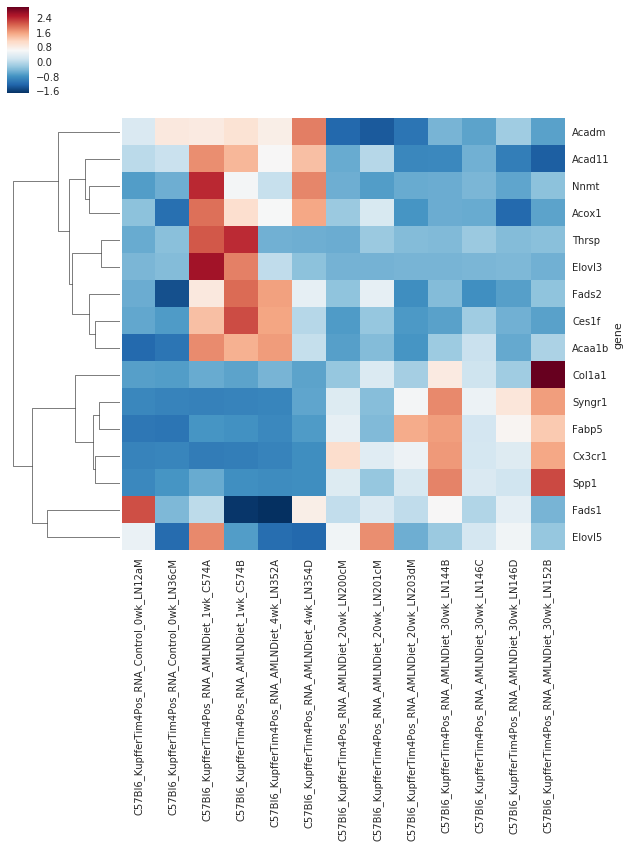

In [47]:
sns.clustermap(tpm_mat_filt.loc[de_sermut_genes, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False)

### Look at LXR and SREBP pathways

SREBP pathway

In [48]:
chol_met_proc = hbUtils.pull_go_terms("GO:0008203", taxon_id='10090', product_type='protein')
chol_met_proc = [entry[1] for entry in chol_met_proc]
chol_biosyn_proc = hbUtils.pull_go_terms("GO:0006695", taxon_id='10090', product_type='protein')
chol_biosyn_proc = [entry[1] for entry in chol_biosyn_proc]

srebp = list(set(chol_biosyn_proc + chol_met_proc))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


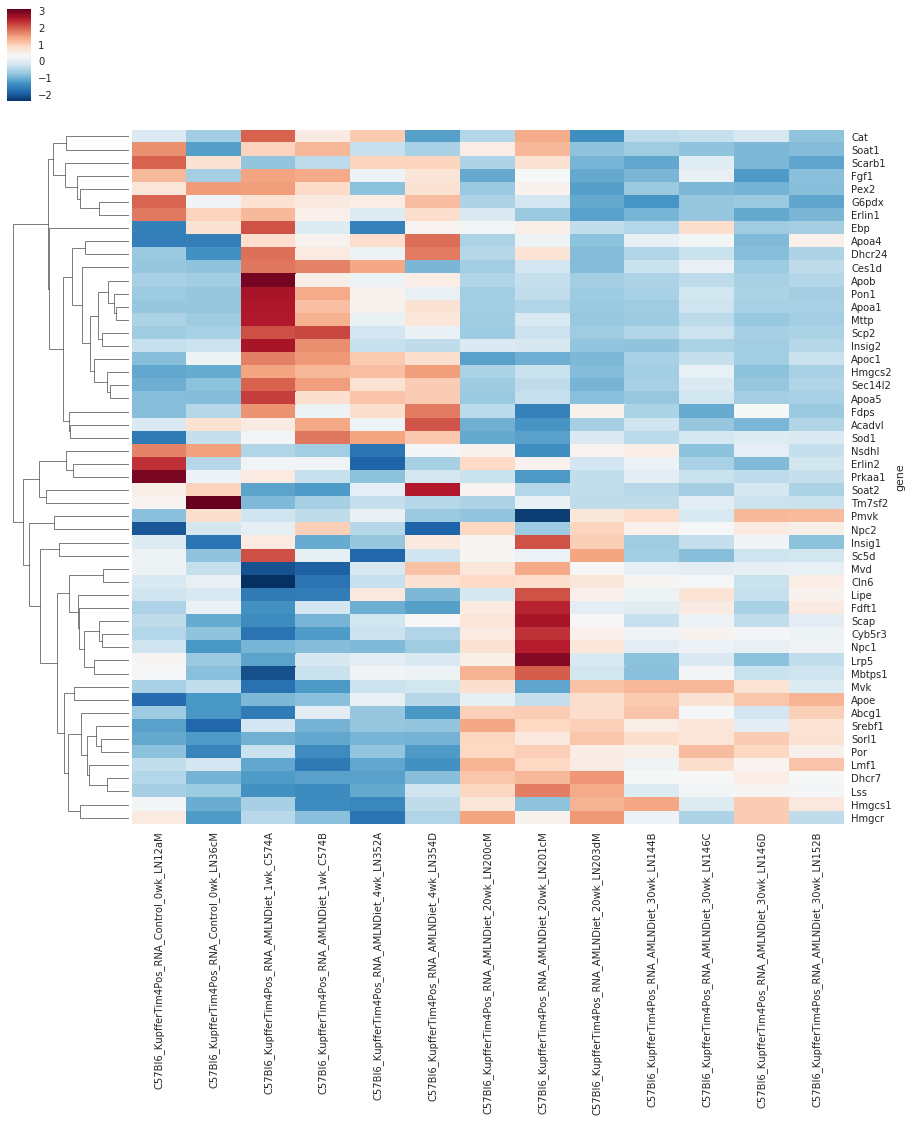

In [49]:
sns.clustermap(tpm_mat_filt.loc[srebp, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

LXR Pathway

In [50]:
with open('/home/h1bennet/data/gene_lists/mouse/LXRDKODown2foldGenes.txt') as f:
    lxrko_down = [i.strip() for i in f.readlines()]
    
with open('/home/h1bennet/data/gene_lists/mouse/LXRDKOUp2foldGenes.txt') as f:
    lxrko_up = [i.strip() for i in f.readlines()]

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


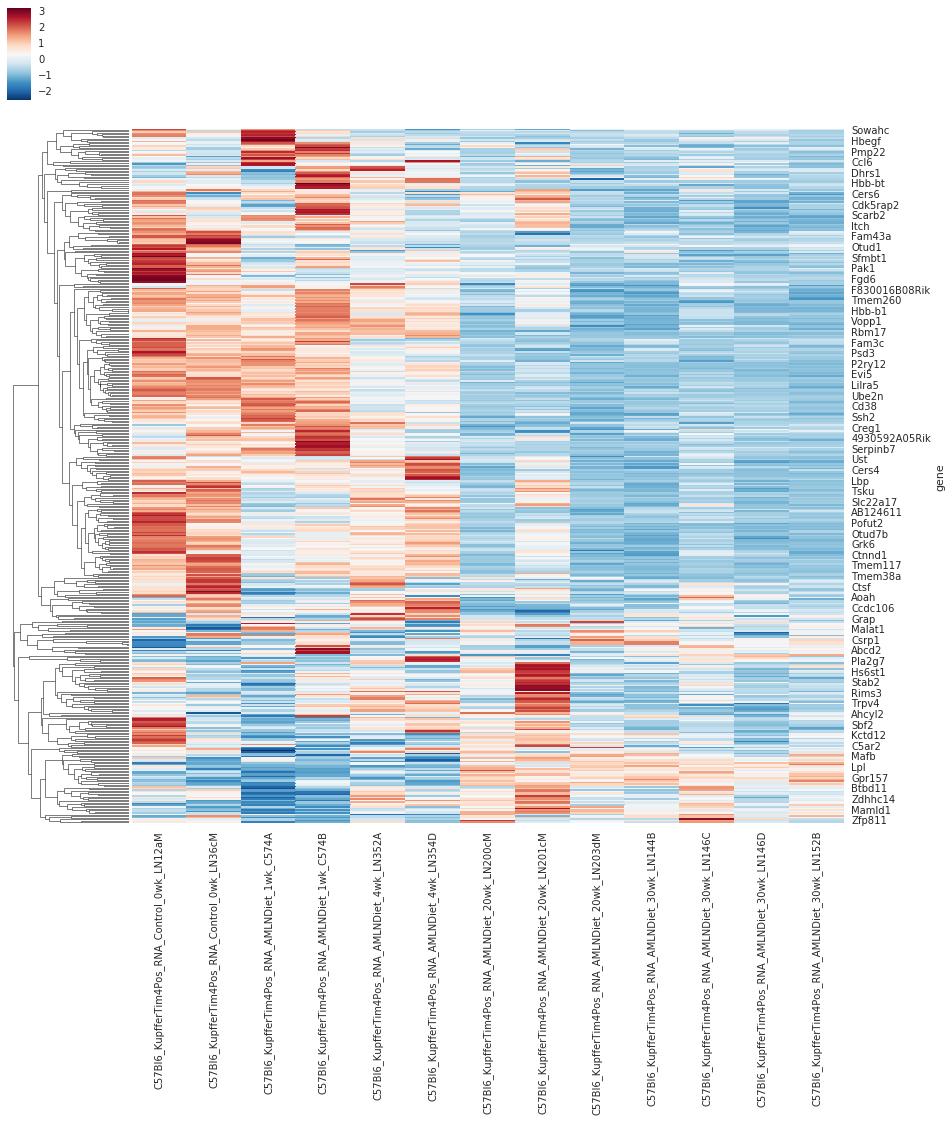

In [51]:
sns.clustermap(tpm_mat_filt.loc[lxrko_down, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


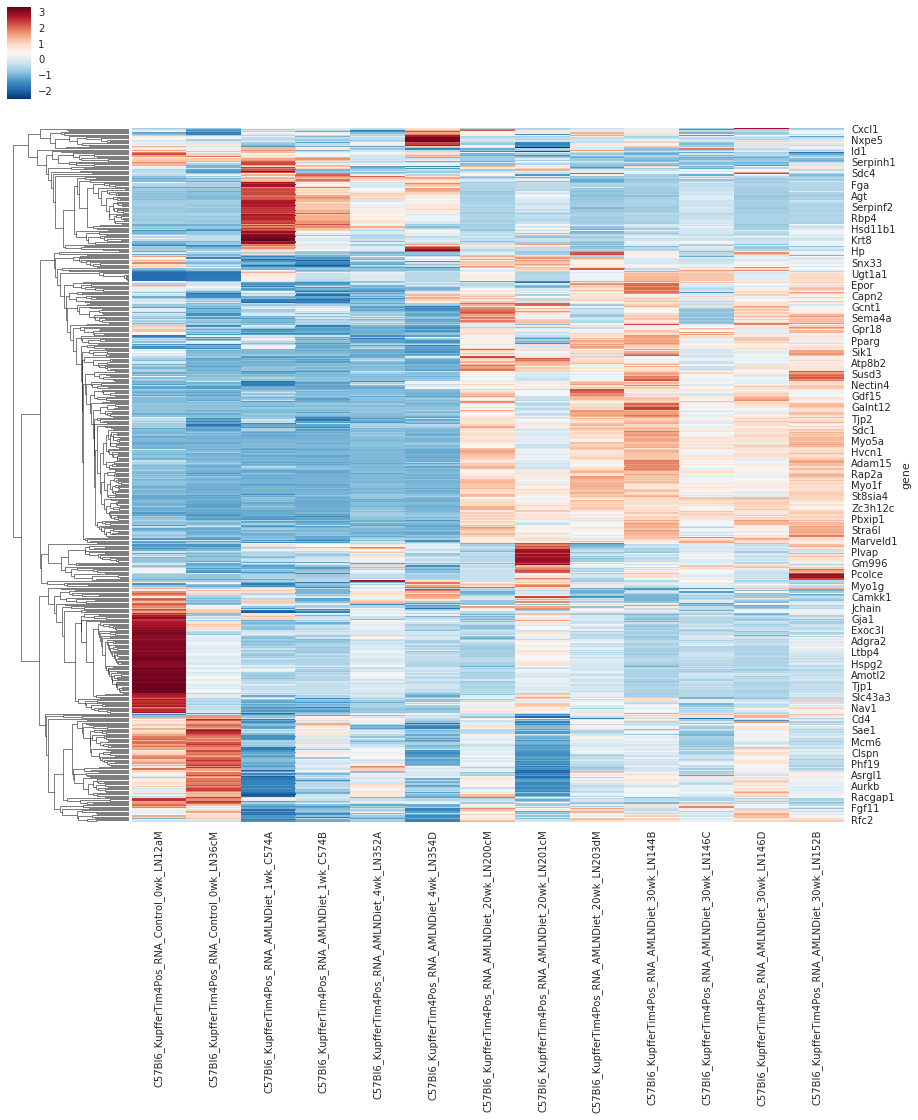

In [52]:
sns.clustermap(tpm_mat_filt.loc[lxrko_up, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(15,15))

Compare to interesting LXR Pathway GO terms

In [53]:
pos_reg_lipid_trans = hbUtils.pull_go_terms("GO:0032370", taxon_id='10090', product_type='protein')
pos_reg_lipid_trans = [entry[1] for entry in pos_reg_lipid_trans]
pos_reg_chol_eff = hbUtils.pull_go_terms("GO:0010875", taxon_id='10090', product_type='protein')
pos_reg_chol_eff = [entry[1] for entry in pos_reg_chol_eff]
# lipid_biosyn_proc = hbUtils.pull_go_terms("GO:0008610", taxon_id='10090', product_type='protein')
# lipid_biosyn_proc = [entry[1] for entry in lipid_biosyn_proc]
trigly_met_proc = hbUtils.pull_go_terms("GO:0006641", taxon_id='10090', product_type='protein')
trigly_met_proc = [entry[1] for entry in trigly_met_proc]
lxr = list(set(pos_reg_lipid_trans + pos_reg_chol_eff + trigly_met_proc))

/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/h1bennet/anaconda3/envs/deseq/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


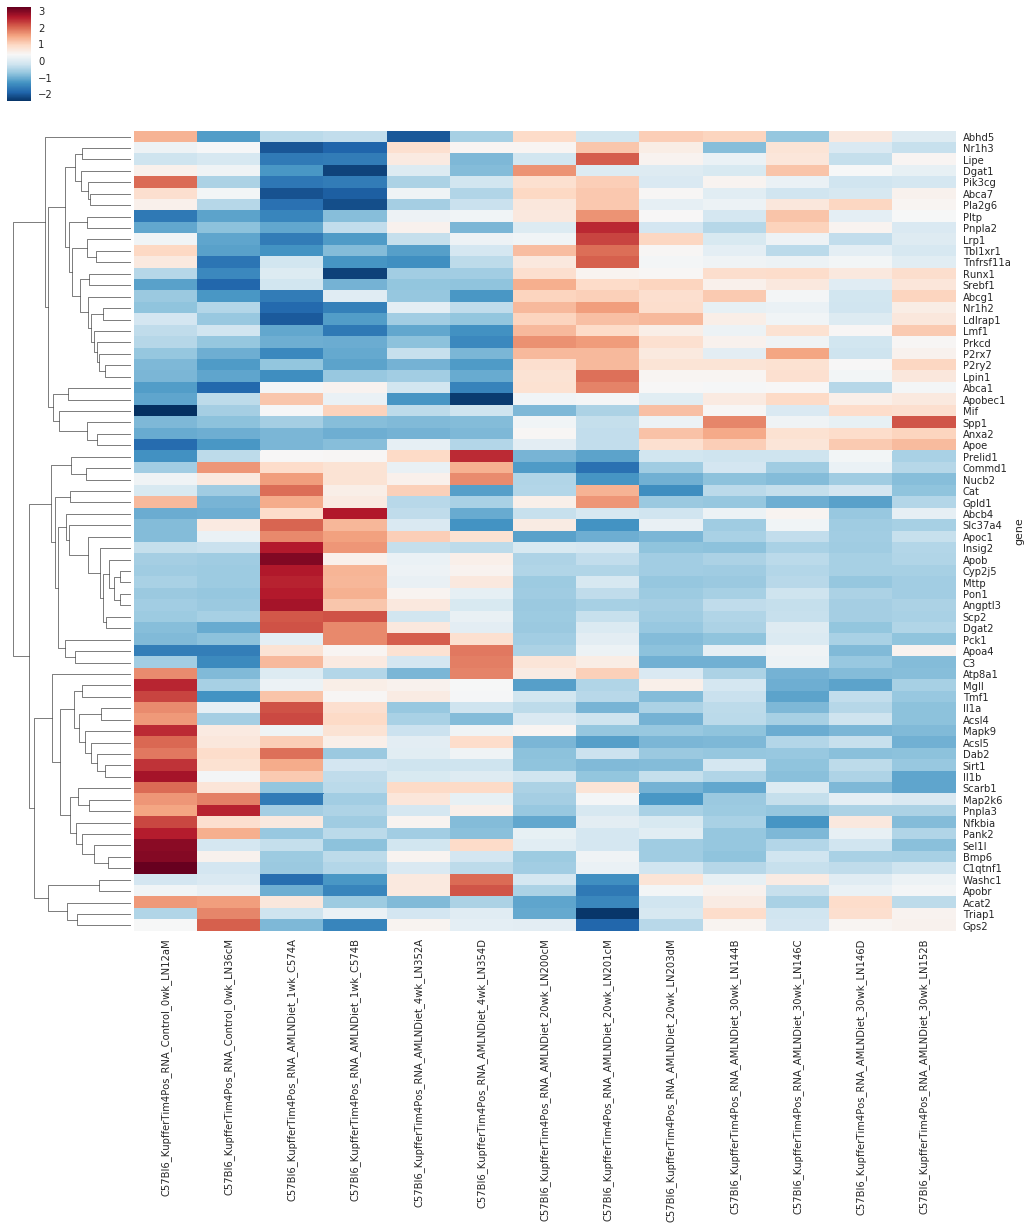

In [54]:
sns.clustermap(tpm_mat_filt.loc[lxr, :].dropna(),
               z_score=0, cmap='RdBu_r', col_cluster=False, figsize=(17,17))